In [12]:
import os, time
import numpy as np, pandas as pd, joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

DATA_DIR = r"C:\Users\aparn\Downloads\adult (1)"
TRAIN_PATH = os.path.join(DATA_DIR, "adult.data")
TEST_PATH  = os.path.join(DATA_DIR, "adult.test")
ARTIFACT_DIR = os.path.join(DATA_DIR, "artifacts")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)

COLS = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

def load_adult(path):
    df = pd.read_csv(path, header=None, names=COLS, na_values=" ?", skipinitialspace=True, comment='|')
    df = df.dropna(how="all")
    df = df[df['age'].astype(str).str.isnumeric()]
    df = df.reset_index(drop=True)
    df['income'] = df['income'].astype(str).str.strip().str.rstrip('.')
    return df

train_df = load_adult(TRAIN_PATH)
test_df  = load_adult(TEST_PATH)

for df in (train_df, test_df):
    df['target'] = (df['income'].str.strip() == ">50K").astype(int)
    df.drop(columns=['income'], inplace=True)

numeric_features = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
categorical_features = [c for c in train_df.columns if c not in numeric_features + ['target']]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder='drop')

X_train_full = train_df.drop(columns=['target'])
y_train_full = train_df['target'].values
X_test = test_df.drop(columns=['target'])
y_test = test_df['target'].values

preprocessor.fit(X_train_full)
X_train_full_proc = preprocessor.transform(X_train_full)
X_test_proc = preprocessor.transform(X_test)

joblib.dump(preprocessor, os.path.join(ARTIFACT_DIR, "adult_preprocessor.joblib"))

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_proc, y_train_full, test_size=0.15, random_state=SEED, stratify=y_train_full
)

use_tf = True
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    tf.random.set_seed(SEED)
except Exception:
    use_tf = False

if use_tf:
    batch_size = 128
    def make_dataset(X, y, batch_size=128, shuffle=False):
        ds = tf.data.Dataset.from_tensor_slices((X.astype('float32'), y.astype('float32')))
        if shuffle:
            ds = ds.shuffle(buffer_size=min(10000, X.shape[0]), seed=SEED)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

    train_ds = make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_ds = make_dataset(X_val, y_val, batch_size=batch_size)
    test_ds = make_dataset(X_test_proc, y_test, batch_size=batch_size)

    def build_mlp(input_dim, hidden=(256,128,64), dropout=0.4):
        inp = keras.Input(shape=(input_dim,), dtype='float32')
        x = inp
        for units in hidden:
            x = layers.Dense(units)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(dropout)(x)
        x = layers.Dense(1)(x)
        probs = layers.Activation('sigmoid')(x)
        return keras.Model(inp, probs)

    model = build_mlp(X_train.shape[1], hidden=(256,128,64), dropout=0.4)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc")
        ]
    )

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]

    model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks, verbose=2)

    probs = model.predict(test_ds).ravel()
    preds = (probs >= 0.5).astype(int)

    acc  = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)
    f1   = f1_score(y_test, preds, zero_division=0)
    try:
        roc  = roc_auc_score(y_test, probs)
    except:
        roc = float('nan')

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc:.4f}")
    print(classification_report(y_test, preds, target_names=['<=50K','>50K'], zero_division=0))
    print(confusion_matrix(y_test, preds))

    pd.DataFrame({"true":y_test,"pred":preds,"prob":probs}).to_csv(os.path.join(ARTIFACT_DIR,"adult_test_predictions.csv"), index=False)

    model_file = os.path.join(ARTIFACT_DIR, "adult_mlp_model.keras")
    try:
        model.save(model_file)
    except:
        tf.saved_model.save(model, os.path.join(ARTIFACT_DIR, "adult_mlp_savedmodel"))

else:
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(solver='saga', max_iter=2000)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test_proc)[:,1]
    preds = (probs >= 0.5).astype(int)

    acc  = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)
    f1   = f1_score(y_test, preds, zero_division=0)
    roc  = roc_auc_score(y_test, probs)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc:.4f}")
    print(classification_report(y_test, preds, zero_division=0))
    print(confusion_matrix(y_test, preds))

    joblib.dump(clf, os.path.join(ARTIFACT_DIR, "adult_logreg_fallback.joblib"))
    pd.DataFrame({"true":y_test,"pred":preds,"prob":probs}).to_csv(
        os.path.join(ARTIFACT_DIR,"adult_test_predictions_logreg.csv"), index=False
    )

print("Artifacts saved to:", ARTIFACT_DIR)


Epoch 1/30
217/217 - 7s - 32ms/step - accuracy: 0.8133 - auc: 0.8535 - loss: 0.3946 - precision: 0.6259 - recall: 0.5583 - val_accuracy: 0.8565 - val_auc: 0.9145 - val_loss: 0.3332 - val_precision: 0.6968 - val_recall: 0.7151 - learning_rate: 0.0010
Epoch 2/30
217/217 - 5s - 21ms/step - accuracy: 0.8383 - auc: 0.8916 - loss: 0.3435 - precision: 0.6863 - recall: 0.6050 - val_accuracy: 0.8598 - val_auc: 0.9166 - val_loss: 0.3092 - val_precision: 0.7137 - val_recall: 0.6973 - learning_rate: 0.0010
Epoch 3/30
217/217 - 3s - 13ms/step - accuracy: 0.8468 - auc: 0.9002 - loss: 0.3310 - precision: 0.7046 - recall: 0.6263 - val_accuracy: 0.8614 - val_auc: 0.9184 - val_loss: 0.3060 - val_precision: 0.7242 - val_recall: 0.6854 - learning_rate: 0.0010
Epoch 4/30
217/217 - 2s - 9ms/step - accuracy: 0.8468 - auc: 0.9023 - loss: 0.3275 - precision: 0.7092 - recall: 0.6165 - val_accuracy: 0.8612 - val_auc: 0.9182 - val_loss: 0.3039 - val_precision: 0.7165 - val_recall: 0.7007 - learning_rate: 0.0010
E

Saved ROC & PR curves to: C:\Users\aparn\Downloads\adult (1)\artifacts\roc_pr_curves.png


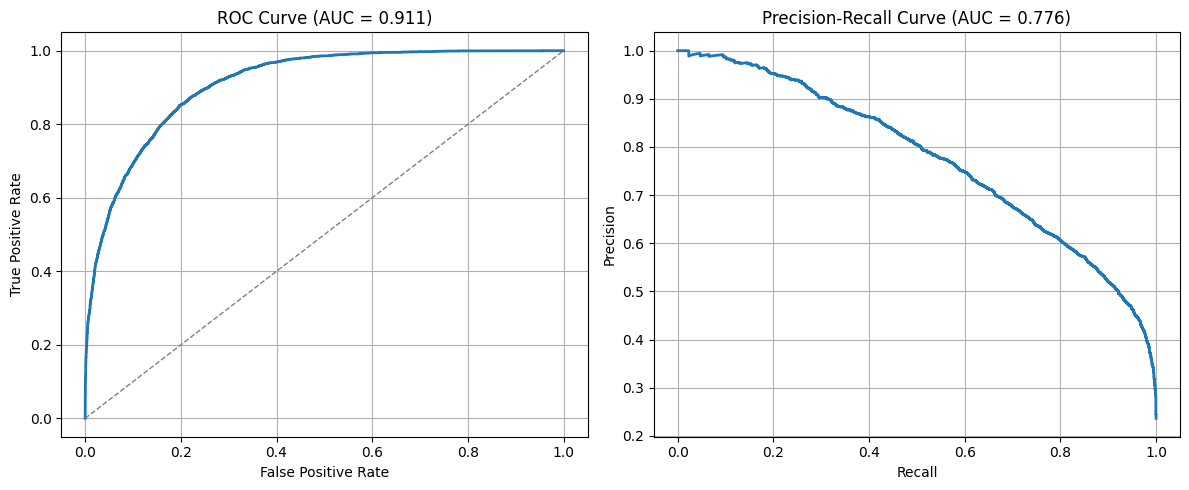

Saved metrics bar chart to: C:\Users\aparn\Downloads\adult (1)\artifacts\core_metrics_bars.png


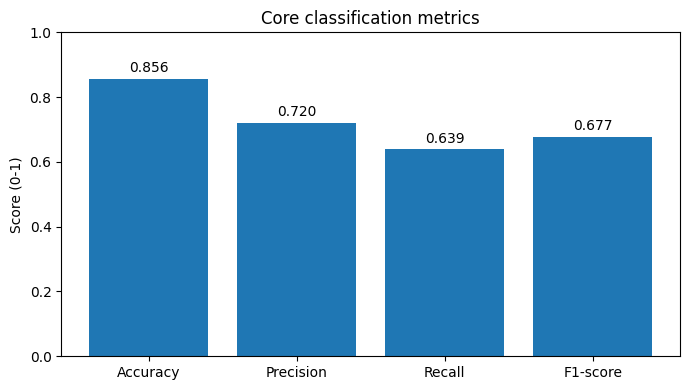

Saved colorful confusion matrix to: C:\Users\aparn\Downloads\adult (1)\artifacts\confusion_matrix_colorful.png


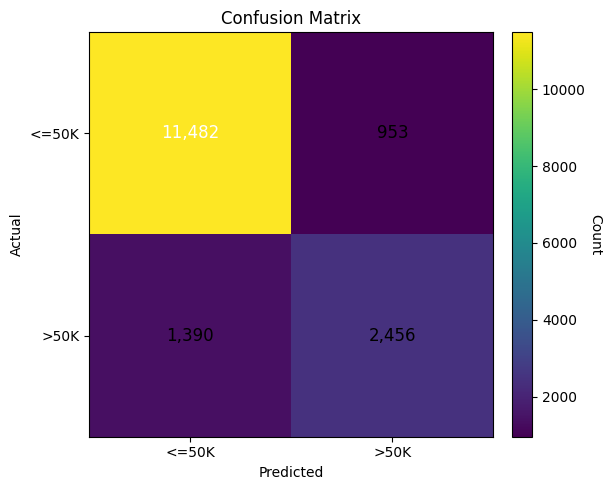

Saved classification report CSV to: C:\Users\aparn\Downloads\adult (1)\artifacts\classification_report_table.csv


AttributeError: 'Styler' object has no attribute 'render'

In [13]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix, accuracy_score

if 'y_test' not in globals() or 'preds' not in globals() or 'probs' not in globals():
    raise RuntimeError("y_test, preds, probs must exist from the training cell. Run that cell first.")

if 'ARTIFACT_DIR' not in globals():
    ARTIFACT_DIR = os.getcwd()
os.makedirs(ARTIFACT_DIR, exist_ok=True)

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

prec_curve, recall_curve, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall_curve, prec_curve)

acc = accuracy_score(y_test, preds)
from sklearn.metrics import precision_score, recall_score, f1_score
prec = precision_score(y_test, preds, zero_division=0)
rec = recall_score(y_test, preds, zero_division=0)
f1 = f1_score(y_test, preds, zero_division=0)

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(fpr, tpr, lw=2)
ax1.plot([0,1],[0,1], linestyle='--', color='gray', lw=1)
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title(f"ROC Curve (AUC = {roc_auc:.3f})")
ax1.grid(True)

ax2.plot(recall_curve, prec_curve, lw=2)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title(f"Precision-Recall Curve (AUC = {pr_auc:.3f})")
ax2.grid(True)

plt.tight_layout()
roc_png = os.path.join(ARTIFACT_DIR, "roc_pr_curves.png")
fig1.savefig(roc_png, dpi=200)
print("Saved ROC & PR curves to:", roc_png)
plt.show()

metrics_names = ["Accuracy","Precision","Recall","F1-score"]
metrics_values = [acc, prec, rec, f1]
fig2, ax = plt.subplots(figsize=(7,4))
bars = ax.bar(metrics_names, metrics_values)
ax.set_ylim(0,1)
ax.set_title("Core classification metrics")
ax.set_ylabel("Score (0-1)")
for bar, val in zip(bars, metrics_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.3f}", ha='center')
plt.tight_layout()
metrics_png = os.path.join(ARTIFACT_DIR, "core_metrics_bars.png")
fig2.savefig(metrics_png, dpi=200)
print("Saved metrics bar chart to:", metrics_png)
plt.show()

cm = confusion_matrix(y_test, preds)
labels = ['<=50K','>50K']

fig3, ax = plt.subplots(figsize=(6,5))
cmap = plt.cm.viridis
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels); ax.set_yticklabels(labels)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i,j]
        color = "white" if val > thresh else "black"
        ax.text(j, i, f"{val:,d}", ha="center", va="center", color=color, fontsize=12)

cbar = fig3.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=270, labelpad=12)
plt.tight_layout()
cm_png = os.path.join(ARTIFACT_DIR, "confusion_matrix_colorful.png")
fig3.savefig(cm_png, dpi=200)
print("Saved colorful confusion matrix to:", cm_png)
plt.show()

report_dict = classification_report(y_test, preds, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T

metrics_cols = ['precision','recall','f1-score']
for c in metrics_cols:
    if c in report_df.columns:
        report_df[c] = report_df[c].astype(float).round(3)
if 'support' in report_df.columns:
    report_df['support'] = report_df['support'].astype(int)

class_rows = [r for r in report_df.index if r not in ('accuracy','macro avg','weighted avg')]
bottom_rows = [r for r in ('accuracy','macro avg','weighted avg') if r in report_df.index]
report_df = report_df.loc[class_rows + bottom_rows]

report_csv = os.path.join(ARTIFACT_DIR, "classification_report_table.csv")
report_df.to_csv(report_csv, index=True)
print("Saved classification report CSV to:", report_csv)

styled = (report_df.style
          .format({"precision":"{:.3f}", "recall":"{:.3f}", "f1-score":"{:.3f}", "support":"{:d}"})
          .background_gradient(subset=['f1-score'], cmap='viridis', axis=0)
          .set_caption("Classification Report (detailed)"))

html_path = os.path.join(ARTIFACT_DIR, "classification_report_table.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(styled.render())
print("Saved styled classification report HTML to:", html_path)

plot_df = report_df.loc[class_rows, metrics_cols].astype(float)
fig4, ax4 = plt.subplots(figsize=(6, 0.9*len(plot_df)))
im2 = ax4.imshow(plot_df.values, aspect='auto', cmap=plt.cm.plasma)
ax4.set_yticks(np.arange(len(plot_df.index))); ax4.set_yticklabels(plot_df.index)
ax4.set_xticks(np.arange(len(plot_df.columns))); ax4.set_xticklabels([c.replace('-',' ').title() for c in plot_df.columns])
ax4.set_title("Per-class metrics (Precision / Recall / F1)")
th = plot_df.values.max()/2.0
for i in range(plot_df.shape[0]):
    for j in range(plot_df.shape[1]):
        val = plot_df.iat[i,j]
        txtc = 'white' if val > th else 'black'
        ax4.text(j, i, f"{val:.3f}", ha='center', va='center', color=txtc)
cbar2 = fig4.colorbar(im2, ax=ax4, fraction=0.046, pad=0.04)
cbar2.ax.set_ylabel("Score", rotation=270, labelpad=12)
plt.tight_layout()
report_heatmap_png = os.path.join(ARTIFACT_DIR, "classification_report_heatmap.png")
fig4.savefig(report_heatmap_png, dpi=200)
print("Saved classification report heatmap to:", report_heatmap_png)
plt.show()

print("\nAll visual artifacts saved to:", ARTIFACT_DIR)
